<a href="https://colab.research.google.com/github/pixelm/notebooks/blob/master/Shipment_carrier_type_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Can you predict the carrier type based on what types of items are being transported?

Build a model that classifies carrier type (tractor, trailer, truck) based on what types of commodities that are carried by that carrier. 

In [0]:
from google.colab import files
uploaded = files.upload()

Saving carrier_equipment.csv to carrier_equipment.csv


In [0]:
uploaded2 = files.upload()

Saving fmcsa_2019-02-15.csv to fmcsa_2019-02-15.csv


In [0]:
import pandas as pd
from pandas import DataFrame as df 
from matplotlib import pyplot as plt
import numpy as np 
import seaborn.apionly as sns
import numpy as np
%matplotlib inline  


# Section 1: Extract and transform

In [0]:
df_carrier_equip = pd.read_csv('carrier_equipment.csv', header=0)
df_carrier_equip.head()

,Unnamed: 0,COMPANY ID,CITY,ST,DOMICILE REGION,ZIP,TRAC,TRAIL,VAN,REFR,INTER,CURT,FLAT,STEP,DD,OVER,TANK,PNEUM,BULK
0,0,1,ANAHEIM,CA,PAC,98444,83,190,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,KENTWOOD,MI,MDW,49508,22,22,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3,SHELBY TOWNSHIP,MI,MDW,48315,26,65,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN
3,3,4,ALLENDALE,MI,MDW,49401,40,55,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5,TROY,MO,CEN,63379,79,99,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df_fmcsa = pd.read_csv('fmcsa_2019-02-15.csv', header=0)
df_fmcsa.rename(columns={'Company ID': 'COMPANY ID'}, inplace=True)
df_fmcsa.rename(columns={'Equipment types Equipment Unit': 'equip_unit'}, inplace=True)
df_fmcsa.rename(columns={'Commodity type Classification': 'commodity_type'}, inplace=True)
df_fmcsa.head()


,Unnamed: 0,COMPANY ID,commodity_type,equip_unit,Company type Type,Equipment types Owned,Equipment types Term Leased,Equipment types Trip Leased
0,1259000,1,BUILDING_MATERIALS,TRACTOR,CARRIER,83.0,0.0,0.0
1,3162076,1,BUILDING_MATERIALS,TRAILER,CARRIER,199.0,0.0,0.0
2,128588,1,LIQUIDS_GASES,TRUCK,CARRIER,17.0,0.0,0.0
3,3229631,1,FARM_SUPPLIES,TRUCK,CARRIER,17.0,0.0,0.0
4,3245723,1,FARM_SUPPLIES,TRACTOR,CARRIER,83.0,0.0,0.0


In [0]:
#isolate all desired equipment types (van, refr, flat)
df_sample_equipment_type = df_carrier_equip[(df_carrier_equip.VAN=='X') | (df_carrier_equip.REFR=='X') | (df_carrier_equip.FLAT=='X')]
df_sample_equipment_type_all = df_sample_equipment_type[['COMPANY ID', 'VAN', 'REFR', 'FLAT']]

#isolate just single equip type as sample for model
df_sample_equipment_type_all['equip_num']=df_sample_equipment_type_all.count(axis='columns')==2 # gives you a column with t/f for equipmenttype as 1 
df_sample_equipment_type_1= df_sample_equipment_type_all.loc[df_sample_equipment_type_all['equip_num']==True] # gives you sample with just TRUE 
df_sample_equipment_type_1 = df_sample_equipment_type_1[['COMPANY ID', 'VAN', 'REFR', 'FLAT']] # dropped unnecessary col equip_num




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [0]:
# clean the main dataset 

df_fmcsa_cleaned = df_fmcsa[['COMPANY ID', 'commodity_type', 'equip_unit']]
df_fmcsa_cleaned['has_TRACTOR'] = (df_fmcsa_cleaned['equip_unit']=='TRACTOR').astype(int)
df_fmcsa_cleaned['has_TRAILER'] = (df_fmcsa_cleaned['equip_unit']=='TRAILER').astype(int)
df_fmcsa_cleaned['has_TRUCK'] = (df_fmcsa_cleaned['equip_unit']=='TRUCK').astype(int)
df_fmcsa_cleaned = df_fmcsa_cleaned[['COMPANY ID', 'commodity_type', 'has_TRACTOR', 'has_TRAILER', 'has_TRUCK']]

df_fmcsa_cleaned_grouped = df_fmcsa_cleaned[['COMPANY ID', 'commodity_type', 'has_TRACTOR', 'has_TRAILER', 'has_TRUCK']].groupby(['COMPANY ID', 'commodity_type']).sum()
df_fmcsa_cleaned_grouped= df_fmcsa_cleaned_grouped.reset_index()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

#Section 2: Exploration

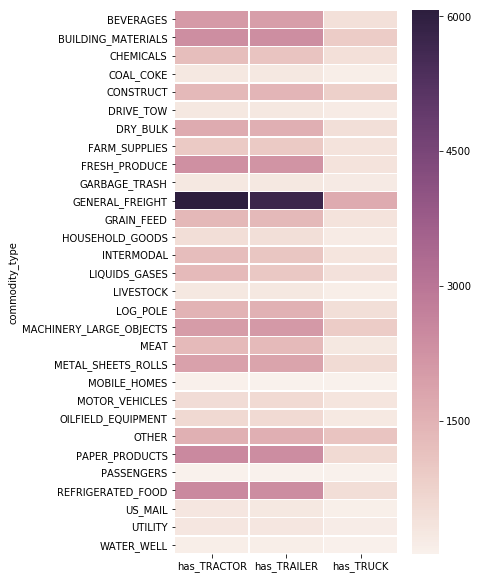

In [0]:
# lets look at the relationship between commodity type and tractor, trailer, truck to see how important those features are. 

df_fmcsa_cleaned_commodity = df_fmcsa_cleaned[['commodity_type', 'has_TRACTOR', 'has_TRAILER', 'has_TRUCK']].groupby(['commodity_type']).sum()

fig, ax = plt.subplots(figsize=(5,10)) 
plt_commodity_vs_equip_unit = sns.heatmap(df_fmcsa_cleaned_commodity, linewidths=.5, ax=ax)

#the plt shows that very few commodity types are corrl with truck. 

####We know that there are a few companies that carry only a single equipment type (van, refr, flat) and we can find matching commodity types for that sample. The rest of the companies carry 2 or more equipement types. 

####Strategy is to isolate the sample with companies that have only single equipment type (van , refr, flat). Use that sample to train a logistic regression model. Then, apply the coefficients of that model to the larger dataset that carry multiple equipment types. 

In [0]:
# inner join the two datasets to isolate a sample of companies that have only single equipment type 
def get_equip(df):
  if df['VAN'] == 'X':
    return 'VAN'
  elif df['REFR']=='X':
    return 'REFR'
  else:
    return 'FLAT'


In [0]:
df_merged = pd.merge(df_sample_equipment_type_1, df_fmcsa_cleaned_grouped, how='inner', on=['COMPANY ID'])
df_merged['equip_type'] = df_merged.apply(get_equip, axis=1)
df_merged = df_merged[['COMPANY ID', 'commodity_type', 'has_TRACTOR', 'has_TRAILER', 'has_TRUCK', 'equip_type']]
df_merged.tail()

,COMPANY ID,commodity_type,has_TRACTOR,has_TRAILER,has_TRUCK,equip_type
15734,6034,METAL_SHEETS_ROLLS,2,2,2,REFR
15735,6034,MOTOR_VEHICLES,1,1,1,REFR
15736,6034,PAPER_PRODUCTS,2,2,2,REFR
15737,6034,REFRIGERATED_FOOD,3,3,2,REFR
15738,6034,UTILITY,2,2,2,REFR


In [0]:
# what % of sample have only one equip type

print (df_merged.shape)
print (df_fmcsa_cleaned_grouped.shape)

pct_data_with_single_equip = df_merged.shape[0]/df_fmcsa_cleaned_grouped.shape[0]
print (pct_data_with_single_equip)

(15739, 6)
(39863, 5)
0.39482728344580187


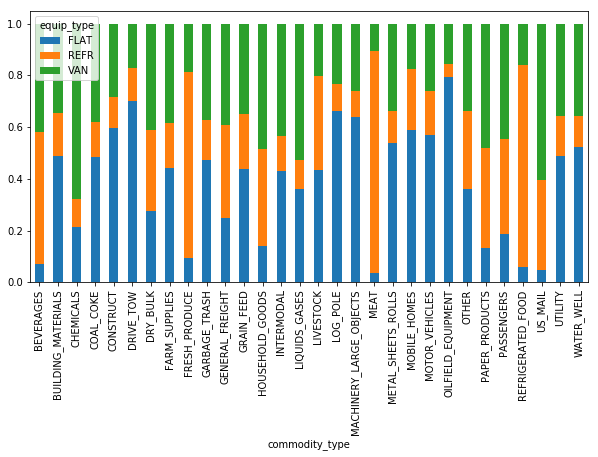

In [0]:
# lets look at the relationship between commodity_type and equip_type 
commodity_vs_equip_ = df_merged
commodity_vs_equip_['ct'] = 1 

commodity_vs_equip_type = pd.pivot_table(commodity_vs_equip_, values='ct', index=['commodity_type'], columns=['equip_type'], aggfunc=np.sum)
commodity_vs_equip_type.head()


commodity_vs_equip_type = commodity_vs_equip_type.div(commodity_vs_equip_type.sum(1), axis=0)
fig, ax = plt.subplots(figsize=(10,5)) 
commodity_vs_equip_type.plot(kind='bar', stacked=True, ax=ax)
# From spot checking the bar chart we can see that some commodities tend to have a majority for a single equipment type but some are more evenly distributed across multipe equipment types. 

#Section 3: Model 

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [0]:
#X_ = df_merged[['commodity_type', 'has_TRACTOR', 'has_TRAILER', 'has_TRUCK']]
X_ = df_merged[['commodity_type']]
y_ = df_merged[['equip_type']]

In [0]:
# hot encoding to turn categorical into numeric encoders 
ct = OneHotEncoder(sparse=False)
X = ct.fit_transform(X_)
X

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [0]:
# encode labels 

lb = LabelEncoder()  
y = lb.fit_transform(y_)
y

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([2, 2, 2, ..., 1, 1, 1])

In [0]:
# split train test 
# split default=0.25
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [0]:
logreg = LogisticRegression(solver='lbfgs',multi_class='multinomial')
logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
x_test_score = logreg.score(X_test, y_test)
print ('logreg score: {:.2f}'  .format(x_test_score))

logreg score: 0.55


In [0]:
# testing a decision tree 
from sklearn.tree import DecisionTreeClassifier
DecisionTree = DecisionTreeClassifier().fit(X_train, y_train)
print('Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Decision Tree classifier on test set: 0.54


In [0]:
print (classification_report(y_test, pred)) # for logistic regression

              precision    recall  f1-score   support

           0       0.56      0.64      0.60      1292
           1       0.71      0.49      0.58      1322
           2       0.43      0.51      0.47      1321

   micro avg       0.55      0.55      0.55      3935
   macro avg       0.57      0.55      0.55      3935
weighted avg       0.57      0.55      0.55      3935



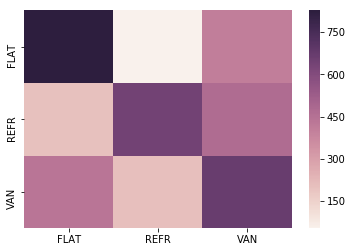

In [0]:
sns.heatmap((confusion_matrix(y_test, pred)), xticklabels=lb.classes_, yticklabels=lb.classes_)


In [0]:
logreg_coeff_= logreg.predict_proba(X_test)
logreg_coeff= df(data=logreg_coeff_, index=None, columns=lb.classes_)
logreg_coeff.head()

,FLAT,REFR,VAN
0,0.074632,0.516442,0.408926
1,0.042399,0.838685,0.118916
2,0.770217,0.066150,0.163633
3,0.292987,0.303165,0.403848
4,0.245830,0.364265,0.389906


In [0]:
# create a table of the x test and coefficients

inverse_enc_X_ = ct.inverse_transform(X_test)
inverse_enc_X= df(data=inverse_enc_X_, index=None, columns=X_.columns)

inverse_enc_y = lb.inverse_transform(y_test)
inverse_enc_y= df(data=inverse_enc_y, index=None, columns=['labels'])

X_test_with_coeff = pd.concat([inverse_enc_X, logreg_coeff, inverse_enc_y], axis=1)
X_test_with_coeff.head()

,commodity_type,FLAT,REFR,VAN,labels
0,BEVERAGES,0.074632,0.516442,0.408926,REFR
1,MEAT,0.042399,0.838685,0.118916,REFR
2,OILFIELD_EQUIPMENT,0.770217,0.066150,0.163633,FLAT
3,DRY_BULK,0.292987,0.303165,0.403848,VAN
4,GENERAL_FREIGHT,0.245830,0.364265,0.389906,VAN


In [0]:
X_test_with_coeff[X_test_with_coeff.commodity_type == 'BEVERAGES'].head(1)

,commodity_type,FLAT,REFR,VAN,labels
0,BEVERAGES,0.074632,0.516442,0.408926,REFR


In [0]:
#lets see how many times the model predicted beverages correctly. Looking at the above graph, it should predict it correctly more then 50%

beverages_df = X_test_with_coeff[X_test_with_coeff['commodity_type']=='BEVERAGES']
beverages_df['labels'].value_counts()

# this shows a simple ratio is better then logistic regression for this commodity type

REFR    114
VAN     107
FLAT     14
Name: labels, dtype: int64

In [0]:
X_test_with_coeff[X_test_with_coeff.commodity_type == 'MEAT'].head(1)

,commodity_type,FLAT,REFR,VAN,labels
1,MEAT,0.042399,0.838685,0.118916,REFR


In [0]:
#lets look at meat 
meat_df = X_test_with_coeff[X_test_with_coeff['commodity_type']=='MEAT']
meat_df['labels'].value_counts()

# the majority is refr which reflects the bar graph above for meat.

REFR    155
VAN      13
FLAT      5
Name: labels, dtype: int64

In [0]:
commodity_type_coeff = X_test_with_coeff.drop(['labels'], axis=1).drop_duplicates()
commodity_type_coeff.shape


(30, 4)

####Given the data that we have, Logistic Regression gives you flexibility in prediction (better then random). However the results are not that great.

####When comparing the regression results with the bar chart above showing distribution of equipment type by commodity type, we can see that sometimes the majority equipment type is a better indicator for prediction then the model.

####In the next iter, I would try pulling in more features (i.e. city, state) to see if that improves the prediction.

In [0]:
#apply the above coeff to the full dataset to predict equip_type
df_fmcsa_coeff_merged = pd.merge(df_fmcsa, commodity_type_coeff, how='left', on=['commodity_type'])

In [0]:
df_fmcsa_coeff_merged.tail()

,Unnamed: 0,COMPANY ID,commodity_type,equip_unit,Company type Type,Equipment types Owned,Equipment types Term Leased,Equipment types Trip Leased,FLAT,REFR,VAN
89607,4020,9995,FARM_SUPPLIES,TRUCK,CARRIER,1.0,0.0,0.0,0.423810,0.174020,0.402171
89608,4021,9996,BUILDING_MATERIALS,TRUCK,CARRIER,5.0,0.0,0.0,0.490306,0.162341,0.347353
89609,4022,9997,FARM_SUPPLIES,TRAILER,CARRIER,0.0,1.0,0.0,0.423810,0.174020,0.402171
89610,4023,9998,UTILITY,TRUCK,CARRIER,0.0,0.0,1.0,0.452101,0.153000,0.394898
89611,4024,9999,FRESH_PRODUCE,TRAILER,CARRIER,1.0,0.0,0.0,0.101410,0.713840,0.184750


In [0]:
df_fmcsa.shape

(89612, 8)

In [0]:
df_fmcsa_coeff_merged.shape

(89612, 11)

In [0]:
# what pct of the main dataset can we classify?

df_fmcsa_coeff_merged['FLAT'].count() / df_fmcsa_coeff_merged.shape[0]

0.990983350444137